# Paper *Self-Supervised Generalisation with Meta Auxiliary Learning*

https://papers.nips.cc/paper/2019/file/92262bf907af914b95a0fc33c3f33bf6-Paper.pdf

Using an auxiliary loss is called auxiliary learning, and is similar to multi-task learning, except that only the primary task is of interest. In our case, the primary task is to output whether image 1 is a digit smaller than image 2. The role of the auxiliary task is to assist in generalization of this primary task.

This paper discusses unsupervised auxiliary learning, for the cases when no label exist for the auxiliary task. Note: this is not our case, we have the original labels $\{0, 1, \dots, 9\}$ from which we deduce the boolean value. Also, the project presentation PDF mentions:

> For the [auxiliary loss], the training can in particular take advantage of the availability of the classes of the two digits in each pair, beside the Boolean value truly of interest. 


# Google paper "Going deeper with convolutions"

https://arxiv.org/abs/1409.4842

https://stats.stackexchange.com/questions/304699/what-is-auxiliary-loss-as-mentioned-in-pspnet-paper



The paper from Google introduced the concept of auxiliary loss. But the focus is to improve very deep networks (they describe a 22-layer long network), whereas we don't really have deep networks for our simple task. The basic idea is to add **auxiliary classifiers connected to intermediate layers**. This is especially useful to **fight gradient vanishing and add regularization**.

### Structure of extra network

1. Average pooling layer
1. 1x1 convolution for dimension reduction and relu activation
1. fully connected and relu
1. dropout (70%)
1. linear layer with softmax loss as classifier

# Draft ideas for Project 1

Based on this [medium article](https://towardsdatascience.com/improve-your-neural-networks-generalization-performance-by-adding-an-unsupervised-auxiliary-loss-4d58b2dead54), we can combine the main loss with the auxiliary loss for the total loss:

$$\text{total loss} = \text{main loss} + \lambda \cdot \text{auxiliary loss}$$

Also, since our network is *not* deep (and can't be, because computations must be rather fast as mentionned in the project description), we should probably put the auxiliary classifier at the end of the network, and not at intermediate levels (as done in Google paper). 

Also, we must combine the main and auxiliary loss in a meaningful way:

* Main loss is currently an accuracy 
* Auxiliary loss would probably be categorical cross entropy

We should probably change the main loss to something more related to the multi-class entropy. 

# Implementation

In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

## dataset build

In [2]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz

--2021-03-08 21:38:53--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-08 21:38:53--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [        <=>         ]  13.79M   591KB/s               ^C


In [3]:
!tar -xf MNIST.tar.gz


In [4]:
!ls MNIST/processed/

test.pt  training.pt


In [2]:
######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    train_set = datasets.MNIST('', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST('', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

In [3]:
train_input , train_target , train_classes , test_input , test_target , test_classes = generate_pair_sets(1000)

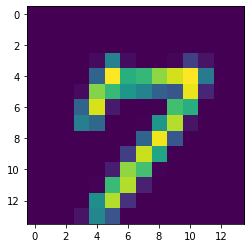

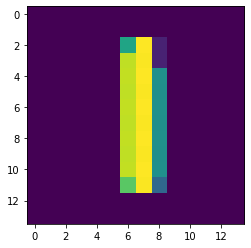

train shape : torch.Size([1000, 2, 14, 14])


In [4]:
plt.imshow( train_input[0][0].numpy() ) 
plt.show()
plt.imshow( train_input[0][1].numpy() ) 
plt.show()
print(f'train shape : {train_input.shape}')

In [5]:
train_dataset = TensorDataset(train_input,train_target , train_classes)
train_dataloader = DataLoader(train_dataset , batch_size=100)

test_dataset = TensorDataset(test_input,test_target , test_classes)
test_dataloader = DataLoader(test_dataset , batch_size=100)


# Fully dense net with aux loss


In [27]:
class FullyDenseNet(nn.Module):
    def __init__(self):
        super(FullyDenseNet, self).__init__()

        self.fc1 = nn.Linear(2*14*14, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.fc1(x) )
        x = torch.relu( self.fc2(x) )
        x = torch.relu( self.fc3(x) )
        x = torch.relu( self.fc4(x) )
        x = self.fc5(x)
        return torch.sigmoid(x)

In [11]:
class FullyDenseNetAux(nn.Module):
    def __init__(self):
        super(FullyDenseNetAux, self).__init__()

        # Network basis: common for all losses
        # 14 * 14 = 196
        self.fc1_im1 = nn.Linear(14*14, 100)
        self.fc1_im2 = nn.Linear(14*14, 100)
        
        self.fc2_im1 = nn.Linear(100, 50)
        self.fc2_im2 = nn.Linear(100, 50)
        
        # Auxiliary networks
        self.fc3_im1 = nn.Linear(50, 10)
        self.fc3_im2 = nn.Linear(50, 10)
        
        # Main task
        self.fc4 = nn.Linear(2*50, 10)
        self.fc5 = nn.Linear(10, 1)

    def forward(self, x):
        im1 = nn.Flatten()(x[:, 0, :, :])
        im2 = nn.Flatten()(x[:, 1, :, :])
        
        im1 = torch.relu(self.fc1_im1(im1))
        im2 = torch.relu(self.fc1_im2(im2))
        
        im1 = torch.relu(self.fc2_im1(im1))
        im2 = torch.relu(self.fc2_im2(im2))
        
        # Main task
        common = torch.cat((im1, im2), dim=1)
        common = torch.relu(self.fc4(common))
        common = self.fc5(common)
        common = F.sigmoid(common)
        
        # Auxiliary networks
        im1 = self.fc3_im1(im1)
        im1 = F.softmax(im1)
        
        im2 = self.fc3_im2(im2)
        im2 = F.softmax(im2)
        
        return common, im1, im2

In [33]:
net = FullyDenseNet()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(net, optimizer, F.binary_cross_entropy)

0 0.6589189767837524 50.91 tensor(0.5844) 48.552
1 0.48521560430526733 50.8760009765625 tensor(0.5688) 48.688
2 0.4298025667667389 51.042001953125 tensor(0.5805) 48.174
3 0.3910297751426697 51.032001953125 tensor(0.5940) 47.886
4 0.36674779653549194 50.912001953125 tensor(0.5776) 48.224
5 0.37001627683639526 50.6360009765625 tensor(0.5107) 49.242
6 0.31918391585350037 50.557998046875 tensor(0.4855) 52.356
7 0.2548154890537262 50.6660009765625 tensor(0.4833) 51.894
8 0.19821672141551971 50.767998046875 tensor(0.4985) 51.838
9 0.1679983139038086 50.792001953125 tensor(0.5085) 51.48
10 0.14728650450706482 50.882001953125 tensor(0.5195) 50.72
11 0.12207827717065811 50.6760009765625 tensor(0.6308) 53.526
12 0.19551147520542145 50.4660009765625 tensor(0.6134) 53.193999999999996
13 0.14905351400375366 51.027998046875 tensor(0.6278) 53.122
14 0.11941385269165039 50.667998046875 tensor(0.5406) 51.824
15 0.13974426686763763 50.9160009765625 tensor(0.5548) 49.45
16 0.13733993470668793 50.84600097

In [32]:
net = FullyDenseNetAux()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(net, optimizer, criterion_=custom_loss)

/home/maousi/anaconda3/envs/ml/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-11-c0597ce55c3e>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  im1 = F.softmax(im1)
<ipython-input-11-c0597ce55c3e>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  im2 = F.softmax(im2)


0 0.3471938669681549 53.2 tensor(0.1102) 56.5
1 -0.07583669573068619 52.3739990234375 tensor(-0.1400) 52.86
2 -0.2540977895259857 51.43 tensor(-0.2573) 50.922
3 -0.3904423117637634 50.8960009765625 tensor(-0.3181) 49.898
4 -0.4854885935783386 50.7860009765625 tensor(-0.3574) 50.07
5 -0.5614346265792847 50.767998046875 tensor(-0.4032) 50.692
6 -0.6354878544807434 50.887998046875 tensor(-0.4307) 50.268
7 -0.7142586708068848 50.917998046875 tensor(-0.4408) 50.552
8 -0.7655872106552124 50.93 tensor(-0.4552) 49.972
9 -0.8210858106613159 50.96 tensor(-0.5064) 51.076
10 -0.8529136776924133 50.91 tensor(-0.5105) 51.258
11 -0.8885366320610046 51.06 tensor(-0.4908) 50.496
12 -0.9068744778633118 50.852001953125 tensor(-0.5312) 51.614
13 -0.7646325826644897 50.787998046875 tensor(-0.5017) 53.354
14 -0.8853691816329956 51.047998046875 tensor(-0.6560) 51.618
15 -1.0521290302276611 50.89 tensor(-0.6639) 51.244
16 -1.1075416803359985 50.887998046875 tensor(-0.6694) 51.342
17 -1.138146162033081 50.8160

# Train tools

In [6]:
def custom_loss(output, target, classes):
    main, im1, im2 = output
    
    main_loss = F.binary_cross_entropy(main.flatten(), target)
    aux_loss_1 = F.nll_loss(im1, classes[:, 0])
    aux_loss_2 = F.nll_loss(im2, classes[:, 1])
    
    return main_loss + aux_loss_1 + aux_loss_2

In [31]:
def handle_loss(criterion):
  if criterion is not custom_loss:
    internal_criterion = lambda output, target, _: criterion(output.flatten(), target)
    compute_acc = lambda output, target: (target == torch.round(output) ).sum().item()
  else:
    internal_criterion = criterion
    compute_acc = lambda output, target: (target == torch.round(output[0]) ).sum().item()
    
  return internal_criterion, compute_acc

In [8]:
def train_epoch(network_ , optimizer_ , criterion = F.binary_cross_entropy ):
  internal_criterion, compute_acc = handle_loss(criterion)
    
  loss_tot = []
  acc_tot = []
  network_.train()
  for batch_idx, (data, target , classes ) in enumerate(train_dataloader):
    optimizer_.zero_grad()
    output = network_(data)
    loss = internal_criterion(output, target.to(torch.float32), classes)
    loss.backward()
    optimizer_.step()

    loss_tot.append(loss.item())
    acc_tot.append( compute_acc(output, target) )
  
  return torch.FloatTensor(loss_tot).mean().item() , torch.FloatTensor(acc_tot).mean().item()/100.0

In [24]:
def test(network_ , criterion_ = F.binary_cross_entropy):
  internal_criterion, compute_acc = handle_loss(criterion_)

  network_.eval()
  test_loss = 0
  acc = 0

  with torch.no_grad():
    for data, target , classes in test_dataloader:
      output = network_(data)
      test_loss += internal_criterion(output, target.to(torch.float32), classes)
      acc += compute_acc(output, target)

  test_loss /= len(test_dataloader)
  acc /= len(test_dataloader)
  return test_loss , acc/100.0

In [39]:
net = FullyDenseNetAux()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(net, optimizer, criterion_=custom_loss)

<ipython-input-11-c0597ce55c3e>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  im1 = F.softmax(im1)
<ipython-input-11-c0597ce55c3e>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  im2 = F.softmax(im2)


0 0.25306418538093567 48.442001953125 tensor(-0.0231) 50.222
1 -0.19650132954120636 50.53 tensor(-0.1727) 48.681999999999995
2 -0.35344260931015015 50.7739990234375 tensor(-0.2374) 47.854
3 -0.45223158597946167 50.5960009765625 tensor(-0.3300) 49.508
4 -0.5171807408332825 50.502001953125 tensor(-0.3838) 49.23
5 -0.6004834175109863 50.6 tensor(-0.4790) 50.532
6 -0.6957592964172363 50.522001953125 tensor(-0.5611) 51.27
7 -0.8166763186454773 50.5460009765625 tensor(-0.5250) 52.626000000000005
8 -0.8450201153755188 50.6560009765625 tensor(-0.5720) 51.382
9 -0.8971213102340698 50.7060009765625 tensor(-0.5629) 51.044
10 -0.9311823844909668 50.647998046875 tensor(-0.5630) 51.251999999999995
11 -0.963970959186554 50.7460009765625 tensor(-0.4387) 49.523999999999994
12 -0.9470165371894836 50.7839990234375 tensor(-0.5763) 50.083999999999996
13 -0.9613487124443054 50.602001953125 tensor(-0.5541) 50.238
14 -1.0090757608413696 50.6339990234375 tensor(-0.5136) 52.95399999999999
15 -0.9839712381362915

In [42]:
def train(network_ , optimizer_ , criterion_ = F.binary_cross_entropy ,epoch_nb = 30,   debug_ = True):

  tot_train_loss = []
  tot_train_acc = []
  tot_test_loss = []
  tot_test_acc = []


  for epoch in range(epoch_nb):
    train_loss , train_acc = train_epoch(network_ , optimizer_ , criterion_)
    test_loss , test_acc = test(network_ , criterion_)

    tot_train_loss.append(train_loss)
    tot_train_acc.append(train_acc)
    tot_test_loss.append(test_loss)
    tot_test_acc.append(test_acc)

        passt_loss , test_acc)

  return tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc

IndentationError: unexpected indent (<ipython-input-42-d5b1ccc08e0a>, line 18)

# stats

In [16]:
def train_multiple_runs( network_class , runs = 10 , epoch = 30):
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = [],[],[],[]
  
  for i in range(runs):
    n = network_class()
    optimizer = optim.SGD(n.parameters(), lr=0.01, momentum=0.5)
    criterion = F.binary_cross_entropy

    tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(n , optimizer , criterion , epoch , debug_ = False)
    all_train_loss.append(tot_train_loss)
    all_train_acc.append(tot_train_acc)
    all_test_loss.append(tot_test_loss)
    all_test_acc.append(tot_test_acc)

  return all_train_loss , all_train_acc , all_test_loss , all_test_acc

In [17]:
def plot_loss_acc( tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc ):
  epochs = range(1, len(tot_train_loss)+1 )
  plt.plot(epochs, tot_train_loss, 'g', label='Training loss')
  plt.plot(epochs, tot_test_loss, 'b', label='Test loss')
  plt.plot(epochs, tot_train_acc, 'r', label='Training acc')
  plt.plot(epochs, tot_test_acc, 'y', label='Test acc')
  plt.title('Training and Test loss/acc')
  plt.xlabel('Epochs')
  plt.ylabel('loss/acc')
  plt.ylim((0,1))
  plt.legend()
  plt.show()

In [18]:
import numpy as np
def plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc):
  trl_mean = np.array(all_train_loss).mean(axis = 0)
  tel_mean = np.array(all_train_acc).mean(axis = 0)
  tra_mean = np.array(all_test_loss).mean(axis = 0)
  tea_mean = np.array(all_test_acc).mean(axis = 0)

  trl_std = np.array(all_train_loss).std(axis = 0)
  tel_std = np.array(all_train_acc).std(axis = 0)
  tra_std = np.array(all_test_loss).std(axis = 0)
  tea_std = np.array(all_test_acc).std(axis = 0)

  epochs = range(1, len(tea_std)+1 )

  temp = [ [trl_mean , trl_std] , [tel_mean , tel_std] , [tra_mean , tra_std] , [tea_mean , tea_std] ]

  for g in temp : 
    plt.plot( epochs , g[0] )
    plt.fill_between(epochs, g[0]-g[1], g[0]+g[1] ,alpha=0.3)

  plt.ylim((-0.1,1.1))
